In [2]:
import numpy as np
from scipy.special import legendre, loggamma
from matplotlib import pyplot as plt

Uvažujme regresní úlohu pro data $(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)$, kde
<ul>
    <li> $x_i\in\langle -1, 1\rangle$, $y_i\in \mathbb R$ </li>
    <li> $y_i = F(x_i) + \epsilon_i$,
        <ul>
            <li> $F(x) = \sum_{j=0}^d w_j L_j(x)$ </li>
            <li> $L_j$ je Legenderův polynom stupně $j$ </li>
            <li> $w_0, w_1, \ldots, w_d\in\mathbb R$ </li>
            <li> $\epsilon_1, \epsilon_2, \ldots, \epsilon_n$ jsou vzájemně nezávislé veličiny s rozdělením $\mathcal N(0, \sigma^2)$</li>
    </li>
</ul>

In [3]:
# skutecna regresni funkce F(x) generujici data
wT = np.array([1, -0.2, 0.3, 0.5, -0.8]) # pole vah, stupen d=4
dT = len(wT)-1
basisT = [legendre(k) for k in range(dT+1)] # seznam bazovych funkci (Legenderovy polynomy do stupne d) 
sigT = 0.5 # smerodatna odchylka nahodne slozky

def F(x):
    """
    regresni funkce generujici data
    """
    return wT@np.array([b(x) for b in basisT])

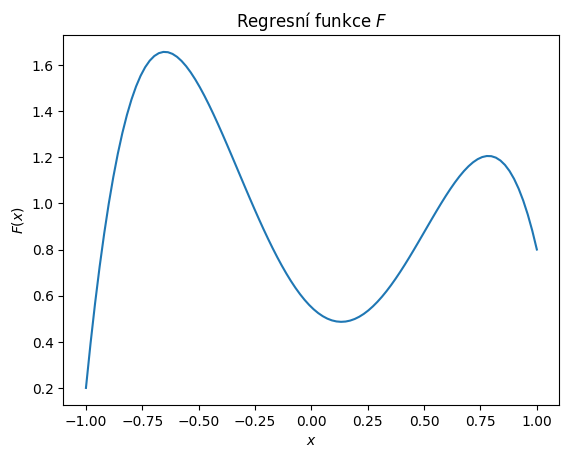

In [4]:
# graf skutecne regresni funkce F
xs = np.linspace(-1, 1, 100)
plt.plot(xs, F(xs))
plt.xlabel('$x$')
plt.ylabel('$F(x)$')
plt.title('Regresní funkce $F$');

In [5]:
# simulovana data
n = 120 # pocet dat
data_x = np.random.uniform(-1, 1, size=n) 
data_y = F(data_x)+np.random.normal(0, sigT, size=n)

Text(0.5, 1.0, 'Data')

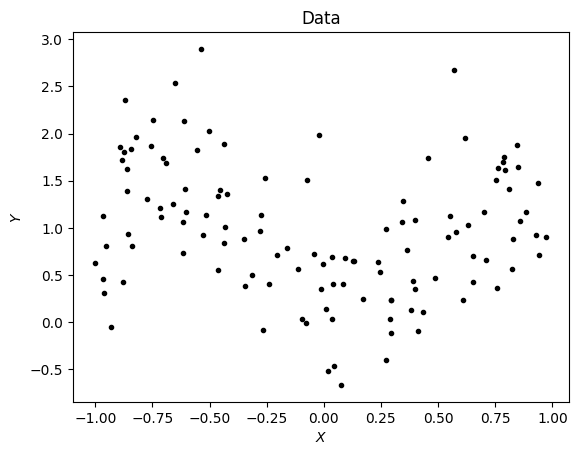

In [7]:
# simulovana data 
#plt.plot(xs, F(xs), alpha=0.5) 
plt.plot(data_x, data_y, 'k.')

plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Data')

In [8]:
def design(x, d):
    """ vytvori matici navrhu z Legenderovych polynomu do stupne d"""
    basis = [legendre(n) for n in range(d+1)]
    return np.hstack([b(x).reshape((-1, 1)) for b in basis])

def LS(x, y, d):
    """ vraci bodovy odhad parametru metodou nejmensich ctvercu """
    X = design(x, d)
    return np.linalg.inv(X.T@X)@X.T@y

def prior(d):
    """ vraci parametry apriorniho rozdeleni """
    a0 = 0.1
    b0 = 0.1
    mu0 = np.zeros(d+1)  
    Lam0 = 0.01*np.eye(d+1) 
    return (a0, b0, mu0, Lam0)

def posterior(x, y, d):
    """ vraci parametry aposteriorniho rozdeleni """
    X = design(x, d)
    n = len(x)
    a0, b0, mu0, Lam0 = prior(d)
    
    LamP = X.T@X + Lam0
    muP = np.linalg.inv(LamP)@(X.T@y + Lam0@mu0)
    aP = a0 + 0.5*n
    bP = b0 + 0.5*(y.T@y + mu0@Lam0@mu0 - muP@LamP@muP)
    
    return (aP, bP, muP, LamP)
    
def logML(x, y, d):
    """ vraci logaritmus marginalni verohodnosti """
    a0, b0, mu0, Lam0 = prior(d)
    aP, bP, muP, LamP = posterior(x, y, d)
    lml = (-0.5*n*np.log(2*np.pi) + 
           0.5*(np.linalg.slogdet(Lam0)[1]-np.linalg.slogdet(LamP)[1]) + 
           a0*np.log(b0)-aP*np.log(bP) +
           loggamma(aP)-loggamma(a0))
    return lml

In [9]:
# hodnoty parametru aposteriorniho rozdeleni 
aP, bP, muP, LamP = posterior(data_x, data_y, dT)

In [12]:
# odhad metodou nejmensich ctvercu
muLS = LS(data_x, data_y, dT)

In [14]:
print(muLS) # odhad
print(wT)   # skuecne

[ 0.94513426 -0.20739382  0.56941678  0.39320822 -0.86272249]
[ 1.  -0.2  0.3  0.5 -0.8]


(0.0, 2.0)

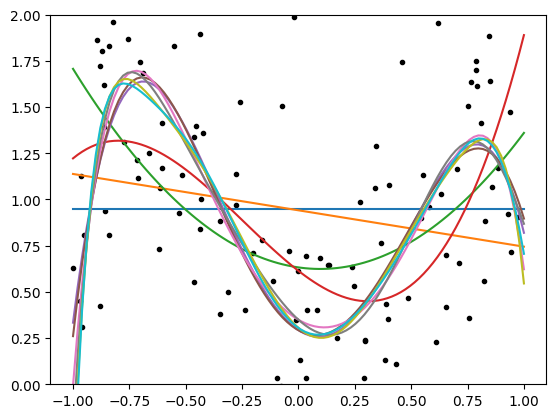

In [19]:
N = 100 # pocet dat pouzitych pro odhad
ds = np.arange(10, dtype=int)
plt.plot(data_x, data_y, 'k.')

# vykresli bodove odhady regresnich funkci (polynomu stupnu 0, ...,d),
# tj. polynomy s koeficienty odpovidajicimi obodvym odhadum
for d in ds:
    muLS = LS(data_x[:N], data_y[:N], d)
    plt.plot(xs, design(xs, d)@muLS)
    
plt.ylim(0, 2)

In [20]:
# nenormalizovane logaritmicke marginalni verohodnosti
lmls = np.array([logML(data_x[:N], data_y[:N], d) for d in ds])
# nenormalizovane marginalni verohodnosti
mls = np.exp(lmls)
# normalizovane marginalni verohodnosti 
# = aposteriorni pravdepodobnosti jednotlivych modelu (pro rovnomerne apriorni rozdleni modelu)
mls = mls/np.sum(mls)



Text(0, 0.5, '$f(m|y_1, \\ldots, y_N$')

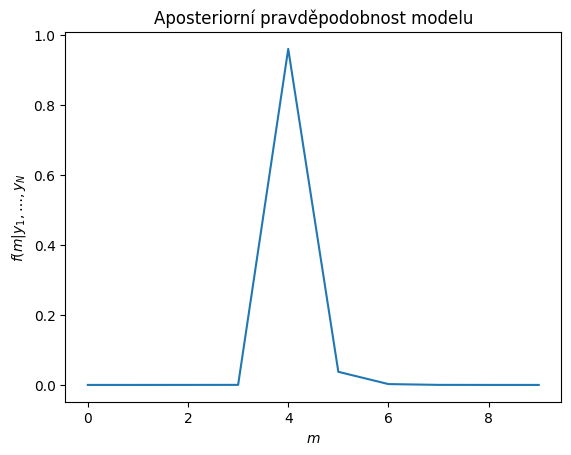

In [25]:
plt.plot(ds, mls)
plt.title("Aposteriorní pravděpodobnost modelu")
plt.xlabel("$m$")
plt.ylabel("$f(m|y_1, \ldots, y_N$")

In [26]:
#data_xy = np.hstack([data_x[:, None], data_y[:, None]])
#np.savetxt('data_xy', data_xy, delimiter=';')
#data = np.genfromtxt('data_xy', delimiter=';')